# $\sqrt{M}$ Poster Plots

# Creating a Kaplan Meier Plot for Column Density & a triple plot that is paper ready

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as lin

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size':22})
#plt.rc({'xtick':22})
#plt.rc({'ytick':22})

import glob as glob

In [2]:
data= pd.read_csv('galfit_spectral_refined_table_for_kirill_w_bval_3.csv')
data.columns

Index(['gal_num', 'id', 'QSO', 'mstars', 'SFR', 'sSFR', 'galaxy_RA',
       'galaxy_DEC', 'redshift', 'xcoord', 'xcoord_error', 'ycoord',
       'ycoord_error', 'int_mag', 'int_mag_error', 'half_light_rad',
       'half_light_rad_error', 'sersic_index', 'sersic_index_error',
       'axis_ratio', 'axis_ratio_error', 'position_angle',
       'position_angle_error', 'reduced_chi_squared', 'azimuthal_angle',
       'inclination_angle', 'is_good_fit', 'shows_internal_struct',
       'overlaps_w_object', 'is_big_galaxy', 'edited', 'double_model', 'zQSO',
       'RA_QSO', 'DEC_QSO', 'survey', 'mstars.1', 'logmhalo', 'rho_comoving',
       'rho_impact', 'rvir', 'rho_rvir', 'gal_type', 'metallicity',
       'panstarrs_i', 'panstarrs_i_err', 'H_I_log10_N_det_thresh',
       'O_VI_log10_N_det_thresh', 'H_I_total_log10_N', 'H_I_log10_N_comps',
       'H_I_log10_N_err_comps', 'H_I_b_comps', 'H_I_b_err_comps',
       'H_I_vcen_comps', 'O_VI_total_log10_N', 'O_VI_log10_N_comps',
       'O_VI_log10_N_

# The KM Plot

In [3]:
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [4]:
def summarize_ion_cd(df, ion):
    is_det_col = ion+'_is_det'
    summary_col = ion+'_summary'
    obs_col = ion+'_total_log10_N'
    thresh_col = ion+'_log10_N_det_thresh'
    
    is_det = df[obs_col]>df[thresh_col]
    summary = np.where(is_det, df[obs_col], df[thresh_col])
    is_det = np.where(np.isnan(df[thresh_col]), np.nan, is_det)
    
    df[is_det_col] = is_det
    df[summary_col] = summary
    return df

In [5]:
summarize_ion_cd(data, ion='H_I')
summarize_ion_cd(data,ion='O_VI');

# applying threshold limits & rho_rvir cut

In [7]:
rho_cut= data[data['rho_rvir']<=1]
h1_cut= rho_cut[rho_cut['H_I_log10_N_det_thresh']<13.5] #29 galx
o6_cut= rho_cut[rho_cut['O_VI_log10_N_det_thresh']<13.5] #31 gals
# data_reduced

In [11]:
h1data= h1_cut[h1_cut['H_I_total_log10_N']>0]
o6data= o6_cut[o6_cut['O_VI_total_log10_N']>0]

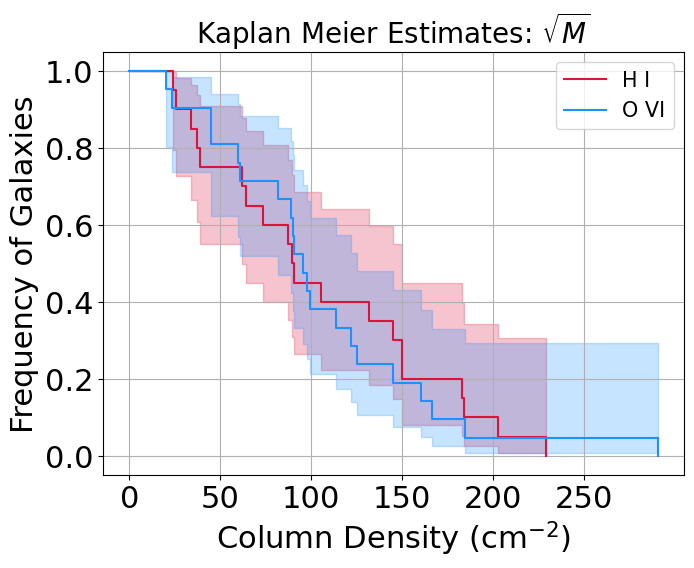

In [15]:
kmf= KaplanMeierFitter()
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.yticks(np.arange(0,1.2, step=0.2))

#h1
X= h1data['sqrt_M_tot_HI']
#Y=h1data['H_I_is_det']
Y=h1data['H_I_is_det']
#o6
#X_o6= o6data['O_VI_total_log10_N']
X_o6= o6data['sqrt_M_tot_OVI']
Y_o6=o6data['O_VI_is_det']

kmf.fit_left_censoring(X, event_observed= Y, label= 'H I')
kmf.plot(color='crimson')
kmf.fit_left_censoring(X_o6, event_observed=Y_o6, label= 'O VI')
kmf.plot(color='dodgerblue')
plt.title("Kaplan Meier Estimates: $\sqrt{M}$", size= 20)
plt.xlabel("Column Density (cm$^{-2}$)")
#plt.xlim(xmin= 13, xmax= 20)
#plt.ylim(ymin=0, ymax=1)
plt.ylabel("Frequency of Galaxies")
plt.grid()
plt.xticks(np.arange(0,300,50))
plt.legend(fontsize=15)
plt.savefig('KMP_sqrtM.png', dpi=300)
plt.show()

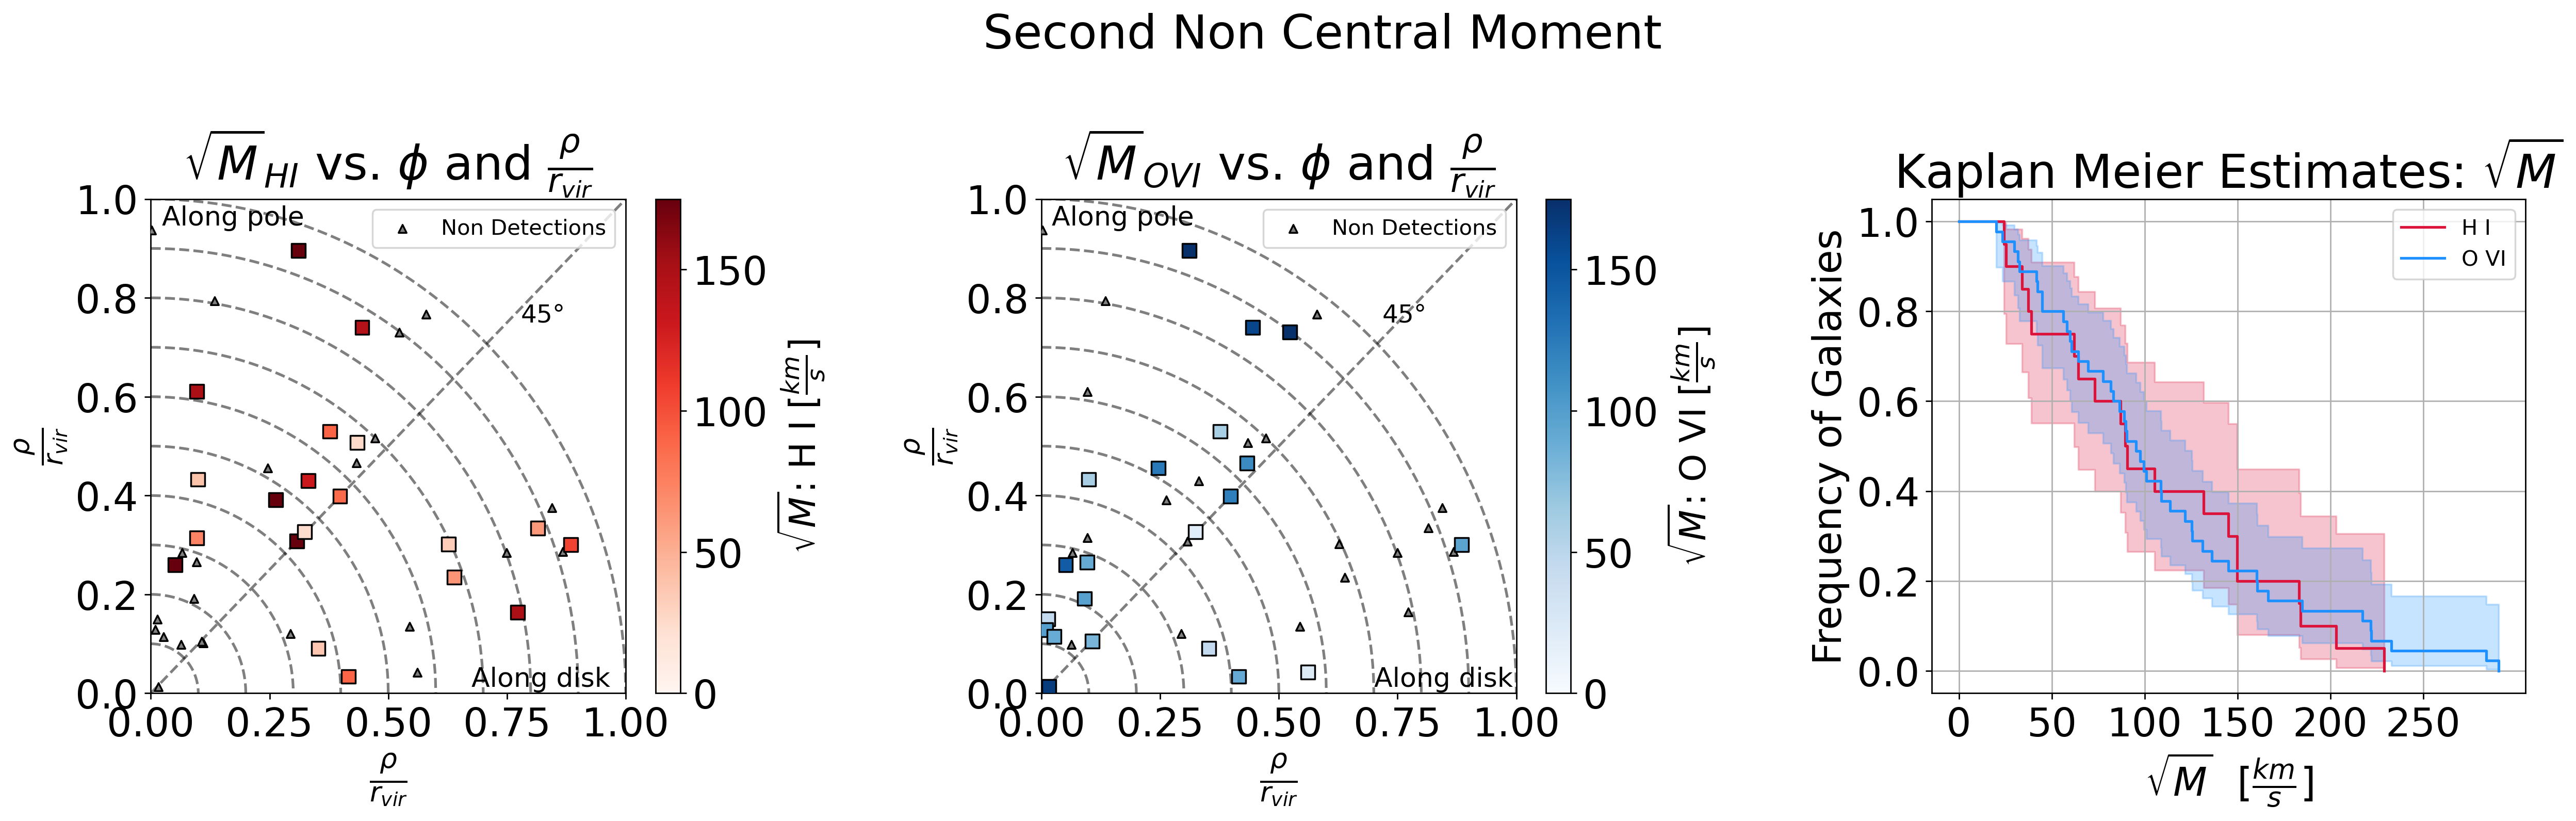

In [22]:
fig, (ax1,ax2, ax3) =plt.subplots(1, 3,dpi=250) #sharey='row' , gridspec_kw={'width_ratios': [1,1]}
fig.set_size_inches(20,5)
fig.tight_layout()
fig.patch.set_facecolor('white')
fig.suptitle('Second Non Central Moment', y=1.2)
# adjusting space between plots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# H I Data

#detections
#using rho_cut to only include galaxies within 1 virial radius
rho_cut= data[data['rho_rvir']<=1]
#threshold cut for h1 (we dont use galaxies that have a threshold thats above 13.5 bc that leaves too much room for noise) 
h1_thresh= rho_cut[rho_cut['H_I_log10_N_det_thresh']<13.5]

df_only_detections_h1 = h1_thresh[h1_thresh['H_I_total_log10_N'] > 0]
rhorvir_detect_h1  = df_only_detections_h1['rho_rvir']
azangles_detect_h1 = df_only_detections_h1['azimuthal_angle']
xvals_detect_h1 = rhorvir_detect_h1 * np.sin(azangles_detect_h1 * (np.pi / 180))
yvals_detect_h1 = rhorvir_detect_h1 * np.cos(azangles_detect_h1 * (np.pi / 180))
HI_sqrtM = df_only_detections_h1['sqrt_M_tot_HI']

#nondetections
rhorvir_nondetect_h1  = rho_cut['rho_rvir']
azangles_nondetect_h1 = rho_cut['azimuthal_angle']
xvals_nondetect_h1 = rhorvir_nondetect_h1 * np.sin(azangles_nondetect_h1 * (np.pi / 180))
yvals_nondetect_h1 = rhorvir_nondetect_h1 * np.cos(azangles_nondetect_h1 * (np.pi / 180))

for i in np.arange(0, 1.1, 0.1):
    r = i
    x = np.linspace(0, r, 1000)
    y = np.sqrt(r**2 - x**2)
    ax1.plot(x, y, c='k', ls='--', alpha=0.5, zorder=1)
    
ax1.plot(np.linspace(0, 10, 100), np.linspace(0, 10, 100), c='k', ls='--', alpha=0.5, zorder=2)
ax1.text(.189, .72, '45$\degree$', fontsize= 14, transform=plt.gcf().transFigure)

# Modify the size of a specific subplot
ax1.set_position([0, 0, 1, 1.2])  # [left, bottom, width, height]

nondetection_h1= ax1.scatter(xvals_nondetect_h1, yvals_nondetect_h1, edgecolor='k', s=20, color= 'gray', zorder=3, marker= '^', label= 'Non Detections') #cmap= 'Blues'
detections_h1 = ax1.scatter(xvals_detect_h1, yvals_detect_h1, c=HI_sqrtM, marker='s', edgecolor='k', s=60, zorder=4, vmin= 0, vmax= 175, cmap= 'Reds') #cmap= 'Blues'

# color bar
#cbar1= plt.colorbar(detections_h1,ax=ax1)
#cbar_h1 = ax1.colorbar(detections_h1)
#cbar_h1.set_label(r'Second Non Central Moment [$\frac{km}{s}$]', size=5)
#cbar1 = fig.colorbar(ax1.scatter(xvals_detect_h1, yvals_detect_h1), ax=ax1)
cbar1 = plt.colorbar(detections_h1, ax=ax1) #ax=ax1
cbar1.set_label(r'$\sqrt{M}$: H I [$\frac{km}{s}$]', size=20)

ax1.text(0.05, .87, 'Along pole', fontsize= 15, transform=plt.gcf().transFigure) 
ax1.text(0.17, .155, 'Along disk', fontsize=15, transform=plt.gcf().transFigure) # transform=plt.gcf().transFigure

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.legend(fontsize=12)
ax1.set_xlabel(r'$\frac{\rho}{r_{vir}}$')
ax1.set_ylabel(r'$\frac{\rho}{r_{vir}}$')
ax1.set_title(r'$\sqrt{M}_{H I}$ vs. $\phi$ and $\frac{\rho}{r_{vir}}$');

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# O VI Data
#threshold cut for h1
o6_thresh= rho_cut[rho_cut['O_VI_log10_N_det_thresh']<13.5]

# detections
df_only_detections = o6_thresh[o6_thresh['O_VI_total_log10_N'] > 0]
rhorvir_detect  = df_only_detections['rho_rvir']
azangles_detect = df_only_detections['azimuthal_angle']
xvals_detect = rhorvir_detect * np.sin(azangles_detect * (np.pi / 180))
yvals_detect = rhorvir_detect * np.cos(azangles_detect * (np.pi / 180))
OVI_sqrtM = df_only_detections['sqrt_M_tot_OVI']

#nondetections
rhorvir_nondetect_o6 = rho_cut['rho_rvir']
azangles_nondetect_o6 = rho_cut['azimuthal_angle']
xvals_nondetect_o6 = rhorvir_nondetect_o6 * np.sin(azangles_nondetect_o6 * (np.pi / 180))
yvals_nondetect_o6 = rhorvir_nondetect_o6 * np.cos(azangles_nondetect_o6 * (np.pi / 180))

# azimuthal lines (visual aid)
for i in np.arange(0, 1.1, 0.1):
    r = i
    x = np.linspace(0, r, 1000)
    y = np.sqrt(r**2 - x**2)
    ax2.plot(x, y, c='k', ls='--', alpha=0.5, zorder=1)

#line @ 45 degrees
ax2.plot(np.linspace(0, 10, 100), np.linspace(0, 10, 100), c='k', ls='--', alpha=0.5, zorder=2)
ax2.text(.523, .72, '45$\degree$', fontsize=14, transform=plt.gcf().transFigure)

detections = ax2.scatter(xvals_detect, yvals_detect, c=OVI_sqrtM, marker='s', edgecolor='k', s=60, zorder=4, vmin=0, vmax= 175, cmap= 'Blues') #cmap= 'Blues'
nondetection_o6= ax2.scatter(xvals_nondetect_o6, yvals_nondetect_o6, edgecolor='k', s=20, color= 'gray', zorder=3, marker= '^', label= 'Non Detections') #cmap= 'Blues'

ax2.set_position([1.4, 0, 1, 1.2])  # [left, bottom, width, height]

cbar = plt.colorbar(detections, ax=ax2)
cbar.set_label(r'$\sqrt{M}$: O VI [$\frac{km}{s}$]', size=20)
#cbar2 = fig.colorbar(ax2(detections), ax=ax2)

ax2.text(0.395, .87, 'Along pole', fontsize= 15, transform=plt.gcf().transFigure) 
ax2.text(0.52, .155, 'Along disk', fontsize=15, transform=plt.gcf().transFigure) # transform=plt.gcf().transFigure
#ax2.set(adjustable='box', aspect='equal')

#ax2.set_aspect('equal')

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend(fontsize=12)
ax2.set_xlabel(r'$\frac{\rho}{r_{vir}}$')
ax2.set_ylabel(r'$\frac{\rho}{r_{vir}}$')
ax2.set_title(r'$\sqrt{M}_{O VI}$ vs. $\phi$ and $\frac{\rho}{r_{vir}}$');

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Kaplan Meier: sqrt M
kmf= KaplanMeierFitter()

#h1
X= df_only_detections_h1['sqrt_M_tot_HI']
#Y=h1data['H_I_is_det']
Y=df_only_detections_h1['H_I_is_det']

#o6
X_o6= o6data_M['sqrt_M_tot_OVI']
Y_o6=o6data_M['O_VI_is_det']

kmf.fit_left_censoring(X, event_observed= Y, label= 'H I')
kmf.plot(color='crimson', ax=ax3)
#kmf.plot(color='crimson')
kmf.fit_left_censoring(X_o6, event_observed=Y_o6, label= 'O VI')
kmf.plot(ax=ax3, color='dodgerblue', xticks=np.arange(0,300,50))
ax3.grid()
ax3.legend(fontsize=12)
ax3.set_xlabel(r'$\sqrt{M}$' r'  $[\frac{km}{s}]$')
ax3.set_ylabel('Frequency of Galaxies')
ax3.set_title('Kaplan Meier Estimates: $\sqrt{M}$')
#bbox_inches= tight prevents it from cropping the png
plt.savefig('secondmoment_test.png', bbox_inches = 'tight');